<a href="https://colab.research.google.com/github/aarush-umap/asl-alphabet-classification/blob/master/classification_google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up imports and google connection

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
GOOGLE = True
import tensorflow as tf

Check GPU availability

In [3]:
gpu = tf.config.list_logical_devices('GPU')[0].name
print(gpu)
print(tf.reduce_sum(tf.random.normal([1000, 1000])))
print(tf.test.is_gpu_available())


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


/device:GPU:0
tf.Tensor(39.738144, shape=(), dtype=float32)
True


In [4]:
tf.debugging.set_log_device_placement(True)

# Create some tensors

with tf.device('/device:GPU:0'):
  a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
  c = tf.matmul(a, b)

print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [5]:
import numpy as np
import os

In [6]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [12]:
if GOOGLE:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install -q kaggle
    ! mkdir ~/.kaggle
    ! cp kaggle.json ~/.kaggle/
    !chmod 600 /root/.kaggle/kaggle.json
    !kaggle datasets download -d grassknoted/asl-alphabet
    !unzip "/content/asl-alphabet.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: /content/dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: /content/dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: /content/dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: /content/dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: /content/dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: /content/dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: /content/dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: /content/dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: /content/dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
if GOOGLE:
    # TODO: Fill in the Google Drive path where you uploaded the assignment
    # Example: If you create a CS_639 folder and put all the files under PS2 folder, then 'CS_639/PS2'
    GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'asl-alphabet'
    GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
    print(os.listdir(GOOGLE_DRIVE_PATH))

['resnet.py', '__pycache__', 'classification_google.ipynb']


In [14]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

## Load all data

### Unzip only if first time using dataset

In [ ]:
if False:
  !unzip "/content/drive/My Drive/asl-alphabet/asl-alphabet.zip" -d "/content/drive/My Drive/asl-alphabet/"

### Use Keras to load train/validation sets

Google based path

In [15]:
if GOOGLE:
    TRAIN_DIR = os.path.join("/content/dataset/", 'asl_alphabet_train', 'asl_alphabet_train')
    TEST_DIR = os.path.join("/content/dataset/", 'asl_alphabet_test', 'asl_alphabet_test')

    img_height = 200
    img_width = 200
    batch_size = 32

Local based filesystem

In [ ]:
if not GOOGLE:
    TRAIN_DIR = os.path.join('asl_alphabet_train', 'asl_alphabet_train')
    TEST_DIR = os.path.join('asl_alphabet_test', 'asl_alphabet_test')

    img_height = 200
    img_width = 200
    batch_size = 32

In [16]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_DIR,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(200, 200),
  batch_size=batch_size)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.


In [17]:
validation_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_DIR,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


In [18]:
classes = train_ds.class_names
print([c for c in classes])

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


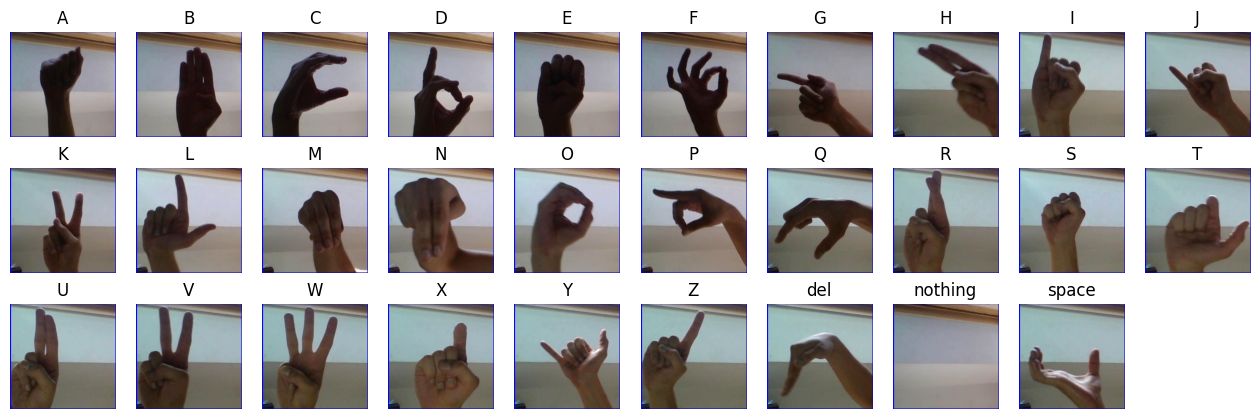

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,5))

for i in range(29):
  ax = plt.subplot(3, 10, i + 1)
  path = TRAIN_DIR + "/{0}/{0}1.jpg".format(classes[i])
  plt.imshow(plt.imread(path))
  plt.title(classes[i])
  plt.axis("off")

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache(filename='/content/image_cache_training/').shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# valiadtion_ds = validation_ds.cache(filename='/content/image_cache_val/').prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valiadtion_ds = validation_ds.prefetch(buffer_size=AUTOTUNE)

## Set up Sequential Model

In [ ]:
num_classes = len(classes)
with tf.device(gpu):
  model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
  ])

In [ ]:
with tf.device('/device:GPU:0'):
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        1

In [ ]:
with tf.device('/device:GPU:0'):
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs
  )

Epoch 1/10
8700/8700 [==============================] - 148s 16ms/step - loss: 0.5856 - accuracy: 0.8166 - val_loss: 0.1211 - val_accuracy: 0.9584
Epoch 2/10
8700/8700 [==============================] - 173s 20ms/step - loss: 0.0914 - accuracy: 0.9705 - val_loss: 0.0900 - val_accuracy: 0.9714
Epoch 3/10
8700/8700 [==============================] - 140s 16ms/step - loss: 0.0573 - accuracy: 0.9828 - val_loss: 0.0805 - val_accuracy: 0.9747
Epoch 4/10
8700/8700 [==============================] - 173s 20ms/step - loss: 0.0429 - accuracy: 0.9865 - val_loss: 0.0301 - val_accuracy: 0.9915
Epoch 5/10
8700/8700 [==============================] - 175s 20ms/step - loss: 0.0372 - accuracy: 0.9892 - val_loss: 0.0462 - val_accuracy: 0.9855
Epoch 6/10
8700/8700 [==============================] - 134s 15ms/step - loss: 0.0317 - accuracy: 0.9914 - val_loss: 0.0405 - val_accuracy: 0.9884
Epoch 7/10
8700/8700 [==============================] - 173s 20ms/step - loss: 0.0301 - accuracy: 0.9924 - val_loss: 0

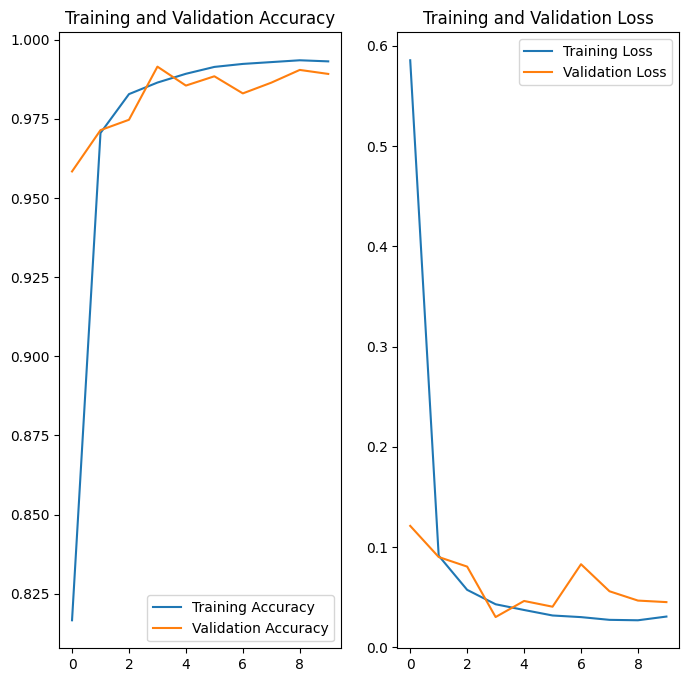

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Use Custom ResNet50

In [21]:
from resnet import ResNet50

# net50 = Sequential ([layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                    #  ResNet50(num_classes=29)])

net50 = Sequential ([layers.Rescaling(1./255),
                     ResNet50(num_classes=29)])

In [24]:
checkpoint_callbacks = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/My Drive/asl-alphabet/best_weights',
    verbose=1,
    save_best_only = True,
    monitor='val_loss',
    mode='min'
    )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.001)

adam_optimizer = tf.keras.optimizers.Adam()

### Define optimizer, loss function, and metrics to track

Optimizer is Adam
Loss is Categorical Cross Entropy, using sparsely defined labels (not one-hot encoded)
Metric being focused on is accuracy

In [26]:
net50.compile(optimizer=adam_optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']
              )

Display ResNet50 composition

In [ ]:
net50.build((batch_size,200,200,3))
net50.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (8, 200, 200, 3)          0         
                                                                 
 ResNet50 (ResNet)           (8, 29)                   23647133  
                                                                 
Total params: 23647133 (90.21 MB)
Trainable params: 23594013 (90.00 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


### Overfit within 10 epochs

In [27]:
with tf.device('/device:GPU:0'):
  epochs=10
  history = net50.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[checkpoint_callbacks, reduce_lr]
  )

Epoch 1/10
2175/2175 [==============================] - ETA: 0s - loss: 0.7420 - accuracy: 0.7844
Epoch 1: val_loss improved from inf to 0.27701, saving model to /content/drive/My Drive/asl-alphabet/best_weights


2175/2175 [==============================] - 858s 374ms/step - loss: 0.7420 - accuracy: 0.7844 - val_loss: 0.2770 - val_accuracy: 0.9142 - lr: 0.0010
Epoch 2/10
2175/2175 [==============================] - ETA: 0s - loss: 0.1069 - accuracy: 0.9669
Epoch 2: val_loss did not improve from 0.27701
2175/2175 [==============================] - 779s 358ms/step - loss: 0.1069 - accuracy: 0.9669 - val_loss: 9.9156 - val_accuracy: 0.4868 - lr: 0.0010
Epoch 3/10
2175/2175 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 0.9766
Epoch 3: val_loss improved from 0.27701 to 0.10859, saving model to /content/drive/My Drive/asl-alphabet/best_weights


2175/2175 [==============================] - 834s 383ms/step - loss: 0.0785 - accuracy: 0.9766 - val_loss: 0.1086 - val_accuracy: 0.9678 - lr: 0.0010
Epoch 4/10
2175/2175 [==============================] - ETA: 0s - loss: 0.0542 - accuracy: 0.9839
Epoch 4: val_loss did not improve from 0.10859
2175/2175 [==============================] - 806s 371ms/step - loss: 0.0542 - accuracy: 0.9839 - val_loss: 1.0313 - val_accuracy: 0.7445 - lr: 0.0010
Epoch 5/10
2175/2175 [==============================] - ETA: 0s - loss: 0.0480 - accuracy: 0.9856
Epoch 5: val_loss did not improve from 0.10859
2175/2175 [==============================] - 806s 371ms/step - loss: 0.0480 - accuracy: 0.9856 - val_loss: 28.4995 - val_accuracy: 0.1564 - lr: 0.0010
Epoch 6/10
2175/2175 [==============================] - ETA: 0s - loss: 0.0383 - accuracy: 0.9884
Epoch 6: val_loss improved from 0.10859 to 0.02293, saving model to /content/drive/My Drive/asl-alphabet/best_weights


2175/2175 [==============================] - 802s 369ms/step - loss: 0.0383 - accuracy: 0.9884 - val_loss: 0.0229 - val_accuracy: 0.9918 - lr: 0.0010
Epoch 7/10
2175/2175 [==============================] - ETA: 0s - loss: 0.0310 - accuracy: 0.9909
Epoch 7: val_loss did not improve from 0.02293
2175/2175 [==============================] - 774s 356ms/step - loss: 0.0310 - accuracy: 0.9909 - val_loss: 2.9748 - val_accuracy: 0.6960 - lr: 0.0010
Epoch 8/10
2175/2175 [==============================] - ETA: 0s - loss: 0.0230 - accuracy: 0.9938
Epoch 8: val_loss did not improve from 0.02293
2175/2175 [==============================] - 775s 356ms/step - loss: 0.0230 - accuracy: 0.9938 - val_loss: 9.2762 - val_accuracy: 0.6462 - lr: 0.0010
Epoch 9/10
2175/2175 [==============================] - ETA: 0s - loss: 0.0151 - accuracy: 0.9956
Epoch 9: val_loss improved from 0.02293 to 0.00596, saving model to /content/drive/My Drive/asl-alphabet/best_weights


2175/2175 [==============================] - 803s 369ms/step - loss: 0.0151 - accuracy: 0.9956 - val_loss: 0.0060 - val_accuracy: 0.9980 - lr: 0.0010
Epoch 10/10
2175/2175 [==============================] - ETA: 0s - loss: 0.0192 - accuracy: 0.9948
Epoch 10: val_loss did not improve from 0.00596
2175/2175 [==============================] - 774s 356ms/step - loss: 0.0192 - accuracy: 0.9948 - val_loss: 0.0256 - val_accuracy: 0.9919 - lr: 0.0010


Display results from overfit

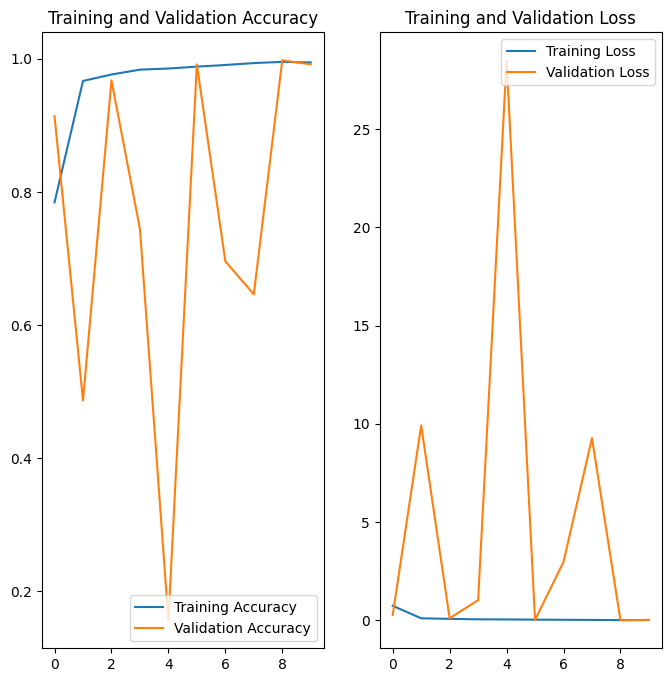

In [28]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
testNet50 = Sequential ([layers.Rescaling(1./255),
                     ResNet50(num_classes=29)])
testNet50.load_weights('/content/drive/My Drive/asl-alphabet/best_weights')

In [34]:
prediction = testNet50.predict(tf.zeros([1,224,224,3]))
print(prediction)

1/1 [==============================] - 0s 25ms/step
[[2.44781083e-13 1.45140254e-18 4.04876951e-18 2.94700828e-17
  5.18383459e-13 5.98579117e-19 6.45002367e-12 5.06232001e-10
  3.06622860e-09 2.09238314e-16 6.39898134e-10 1.11077452e-21
  4.19462362e-15 2.45176492e-16 8.94689814e-23 2.12350292e-15
  3.59574023e-17 1.48580787e-10 6.64290138e-19 1.88540957e-20
  1.10873205e-17 8.98127764e-20 1.71417793e-21 1.98995096e-12
  5.56029683e-17 3.55942853e-15 3.18985980e-15 1.00000000e+00
  5.91739202e-17]]


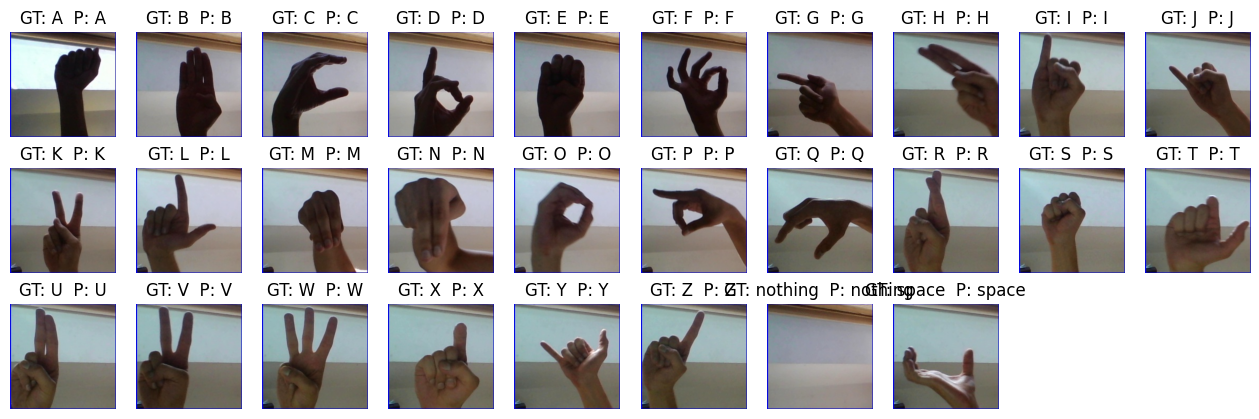

In [36]:
plt.figure(figsize=(16,5))
classes_without_del = [c for c in classes if c != 'del']
for i in range(28):
  ax = plt.subplot(3, 10, i + 1)
  path = TEST_DIR + f"/{classes_without_del[i]}_test.jpg"
  img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)
  prediction = testNet50(img_array)
  predicted_class = classes[np.argmax(prediction)]
  plt.imshow(plt.imread(path))
  plt.title(f'GT: {classes_without_del[i]}  P: {predicted_class}')
  plt.axis("off")